Class Definitions

In [104]:

import heapq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ast
import matplotlib.dates as mdates
from datetime import datetime

# Define the Operation class
class Operation:
    def __init__(self, id, predecessor_operations, end_product, due_date, processing_time, workcenter, machine):
        self.id = id
        self.predecessor_operations = predecessor_operations
        self.end_product = end_product
        self.due_date = due_date
        self.processing_time = processing_time
        self.workcenter = workcenter
        self.machine = machine
        self.start_time = None
        self.end_time = None
        self.scheduled = False


# Define the WorkCenter class
class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines

def load_operations_from_df(df):
    operations = {}
    for _, row in df.iterrows():
        op_id = row['operation']
        operations[op_id] = Operation(
            id=op_id,
            processing_time=row['processing_time'],
            workcenter=row['workcenter'],
            machine=row['machine'],
            predecessor_operations=row['predecessor_operations'] if isinstance(row['predecessor_operations'], list) else [],
            end_product=row['end_product'],
            due_date=row['due_date']
        )
    return operations

def load_factory(df_machine):
    factory = {}
    for _, row in df_machine.iterrows():
        workcenter_id = row['workcenter']
        machines = {machine: [] for machine in df_machine.columns[1:] if row[machine] > 0}
        factory[workcenter_id] = WorkCenter(id=workcenter_id, dict_machines=machines)
    return factory



EDD

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,F.10,[],0,0,2,WC#2,M1
1,F.20,[F.10],0,0,3,WC#1,M1
2,D.10,[],0,0,3,WC#1,M1
3,C.10,"[D.10, F.20]",0,0,1,WC#1,M1
4,A.10,[],0,0,5,WC#1,M1
5,A.20,"[A.10, C.10]",1,14,2,WC#2,M1


,workcenter,M1
0,WC#1,1
1,WC#2,1


Machine: M1, Usages: []
Machine usage: []
Desired start time: 0, Processing time: 2
Operation F.10: Scheduled from 0 to 2 on machine M1 in workcenter WC#2
Machine M1 in workcenter WC#2 usage after scheduling operation F.10: [(0, 2)]
Operation F.20 with no remaining dependencies added to the queue
Operation D.10 with no remaining dependencies added to the queue
Operation A.10 with no remaining dependencies added to the queue
Machine: M1, Usages: []
Machine usage: []
Desired start time: 0, Processing time: 3
Operation D.10: Scheduled from 0 to 3 on machine M1 in workcenter WC#1
Machine M1 in workcenter WC#1 usage after scheduling operation D.10: [(0, 3)]
Operation A.10 with no remaining dependencies added to the queue
Machine: M1, Usages: [(0, 3)]
Machine usage: [(0, 3)]
Desired start time: 2, Processing time: 3
Checking interval: (0, 0)
Checking interval: (3, inf)
Operation F.20: Scheduled from 3 to 6 on machine M1 in workcenter WC#1
Machine M1 in workcenter WC#1 usage after scheduling 

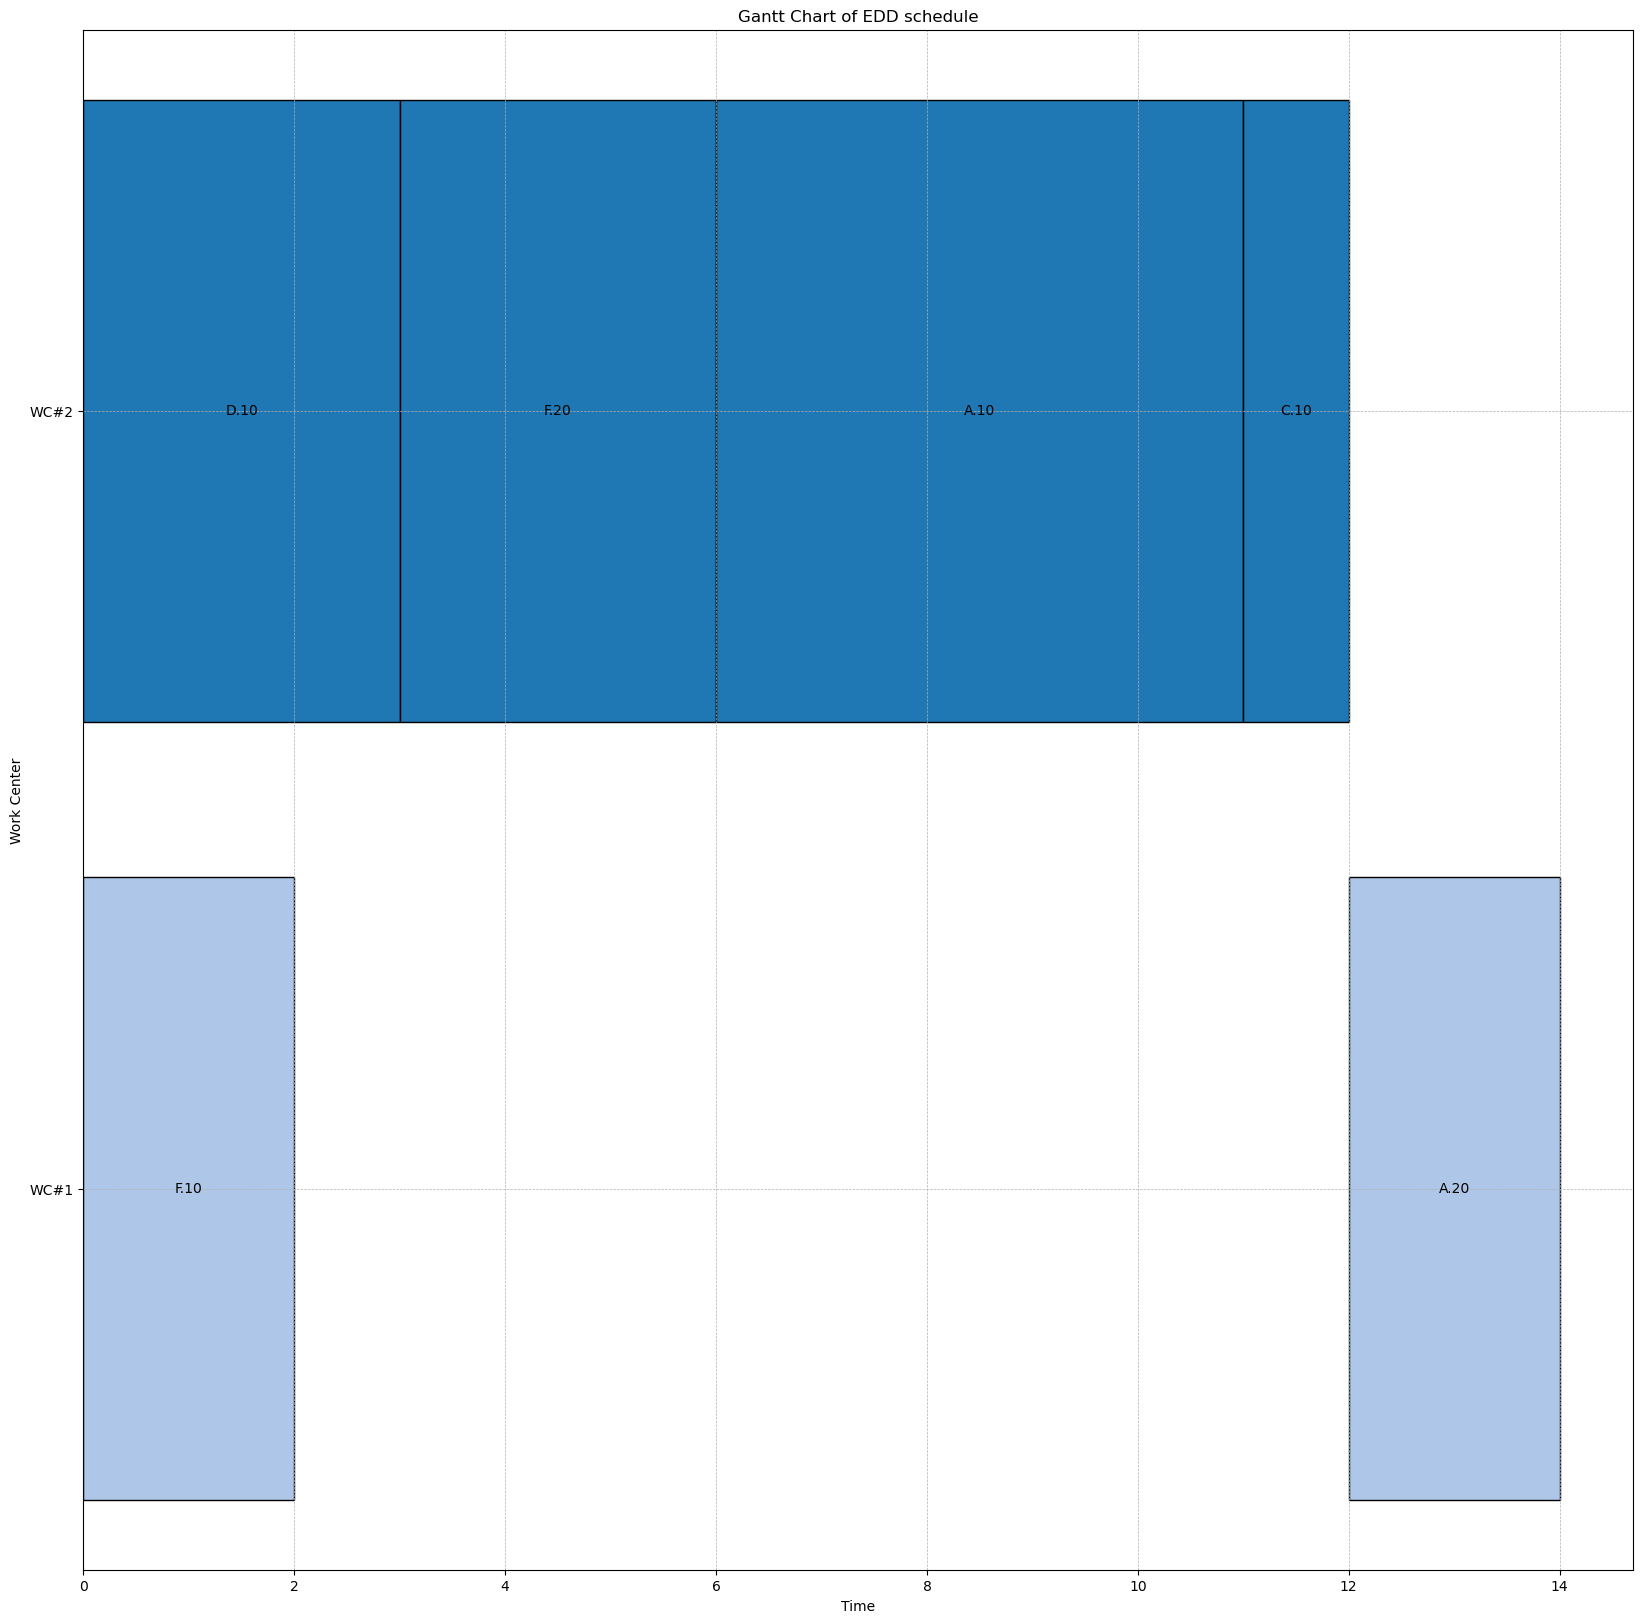

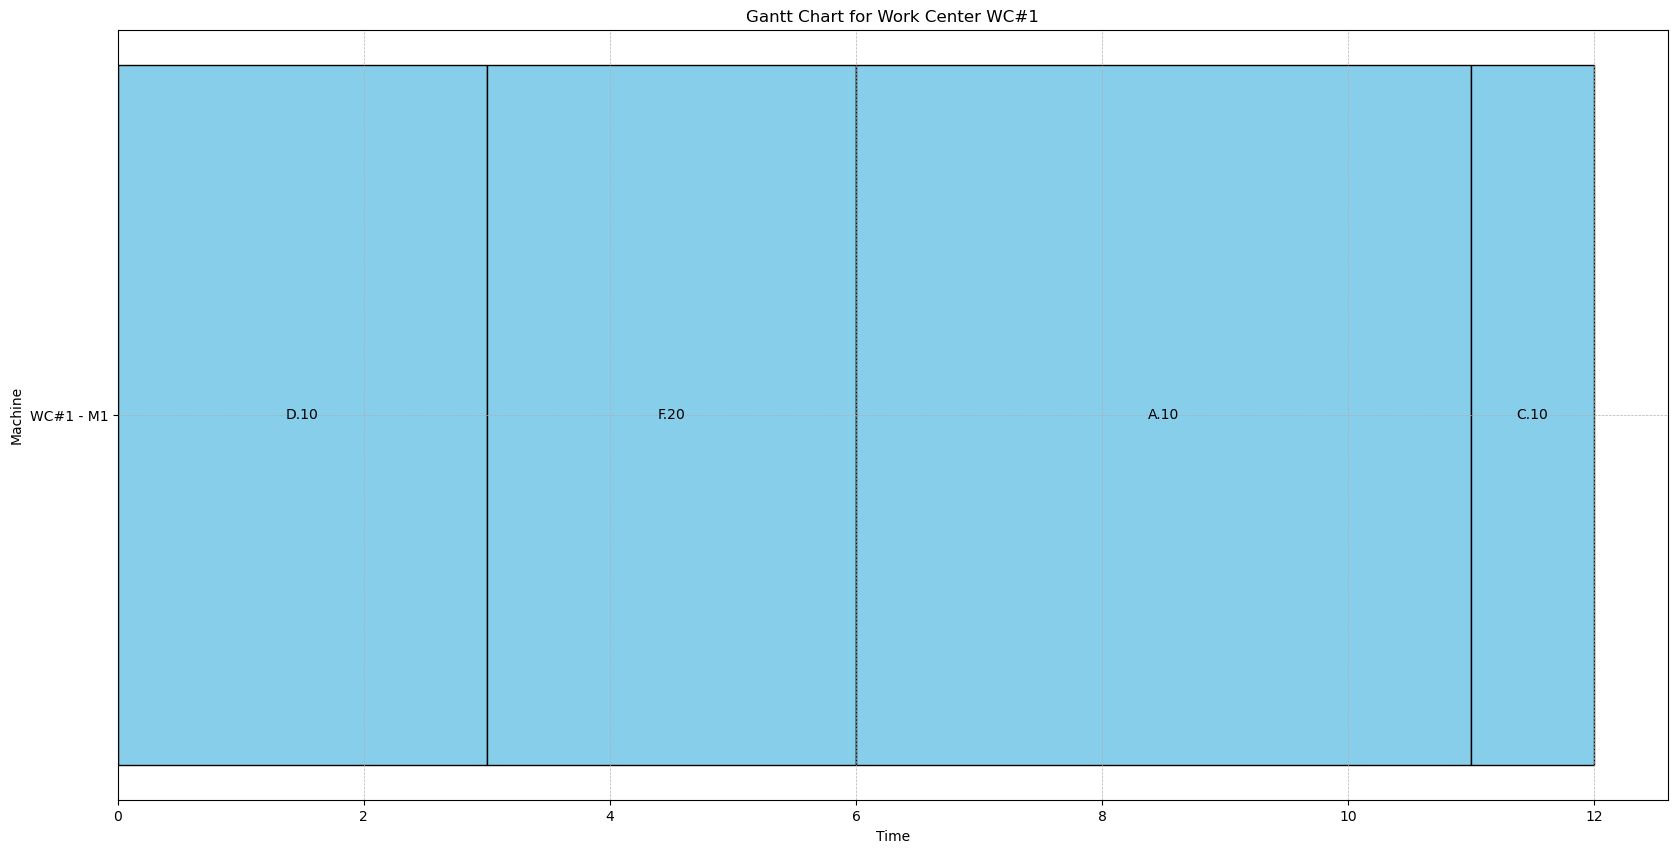

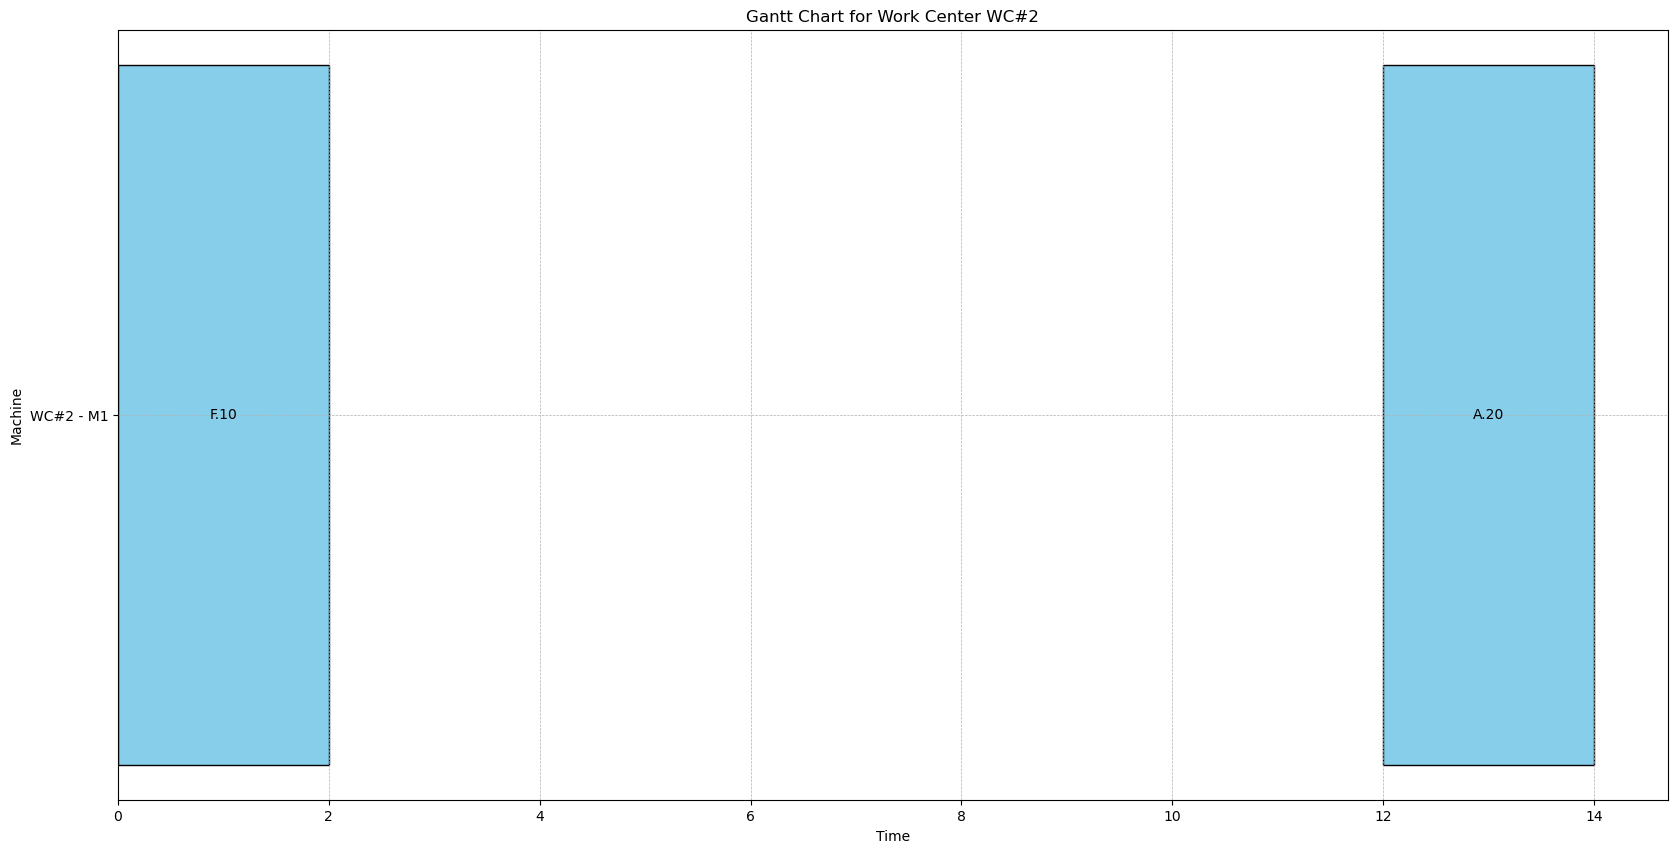

In [105]:
df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], ['F.10'], [], ['D.10', 'F.20'], [], ['A.10', 'C.10']],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})
display(df_BOM)
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [1, 1]
})
display(df_machine)

def find_earliest_start_time(machine_usage, desired_start_time, processing_time):
    """
    Finds the earliest start time on the given machine that avoids overlapping with existing jobs.
    """
    # Ensure machine_usage is a list of tuples
    if not all(isinstance(interval, tuple) and len(interval) == 2 for interval in machine_usage):
        raise ValueError("Machine usage must be a list of tuples with exactly two values each.")
    
    # Flatten the list of usage intervals
    flat_usage = [interval for interval in machine_usage]
    flat_usage.sort()
    
    print(f"Machine usage: {flat_usage}")
    print(f"Desired start time: {desired_start_time}, Processing time: {processing_time}")

    if not flat_usage:
        return desired_start_time

    for i in range(len(flat_usage) + 1):
        if i == 0:
            interval_start = 0
            interval_end = flat_usage[i][0] if len(flat_usage) > 0 else float('inf')
        elif i == len(flat_usage):
            interval_start = flat_usage[i - 1][1]
            interval_end = float('inf')
        else:
            interval_start = flat_usage[i - 1][1]
            interval_end = flat_usage[i][0]

        print(f"Checking interval: ({interval_start}, {interval_end})")

        if desired_start_time >= interval_start and desired_start_time + processing_time <= interval_end:
            return desired_start_time

        if interval_start + processing_time <= interval_end:
            return interval_start

    return desired_start_time





def check_availability(start_time, processing_time, machine_usage):
    """
    Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
    """
    end_time = start_time + processing_time
    for interval in machine_usage:
        if len(interval) != 2:
            raise ValueError("Machine usage interval does not contain exactly 2 values")
        interval_start, interval_end = interval
        if not (end_time <= interval_start or start_time >= interval_end):
            return False
    return True


def schedule_operations(operations, factory):
    scheduled_operations = []
    Q = []
    unscheduled_dependencies = {op_id: len(op.predecessor_operations) for op_id, op in operations.items()}

    # Initialize the queue with operations that have no dependencies, sorted by due dates
    for op_id, count in unscheduled_dependencies.items():
        if count == 0:
            heapq.heappush(Q, (operations[op_id].due_date if operations[op_id].due_date is not None else float('inf'), operations[op_id].processing_time, op_id))

    while Q:
        _, _, operation_id = heapq.heappop(Q)
        operation = operations[operation_id]

        if operation.scheduled:
            continue

        # Compute start time based on dependencies
        if operation.predecessor_operations:
            max_end_time = max(
                (operations[comp_id].end_time if operations[comp_id].end_time is not None else -float('inf'))
                for comp_id in operation.predecessor_operations
            )
            operation.start_time = max_end_time
        else:
            operation.start_time = 0

        # Find the best machine and start time
        workcenter = factory[operation.workcenter]
        best_start_time = float('inf')
        selected_machine = None
        selected_machine_name = None
        
        for machine_name, machine_usages in workcenter.machines.items():
            print(f"Machine: {machine_name}, Usages: {machine_usages}")
            
            # Ensure machine_usages is a list of tuples
            if not all(isinstance(interval, tuple) and len(interval) == 2 for interval in machine_usages):
                raise ValueError(f"Machine usages for {machine_name} in workcenter {operation.workcenter} must be a list of tuples with exactly two values each.")
                
            start_time = find_earliest_start_time(machine_usages, operation.start_time, operation.processing_time)
            if check_availability(start_time, operation.processing_time, machine_usages):
                if start_time < best_start_time:
                    best_start_time = start_time
                    selected_machine = machine_usages
                    selected_machine_name = machine_name

        if selected_machine is None:
            # No available machine found; push operation back to recheck later
            heapq.heappush(Q, (operation.due_date if operation.due_date is not None else float('inf'), operation.processing_time, operation_id))
            print(f"Operation {operation.id} not scheduled yet, re-adding to the queue")
            continue

        # Schedule the operation
        operation.start_time = best_start_time
        operation.end_time = operation.start_time + operation.processing_time
        selected_machine.append((operation.start_time, operation.end_time))
        selected_machine.sort()

        # Debug information
        print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {selected_machine_name} in workcenter {operation.workcenter}")
        print(f"Machine {selected_machine_name} in workcenter {operation.workcenter} usage after scheduling operation {operation.id}: {selected_machine}")

        operation.scheduled = True
        scheduled_operations.append(operation)

        # Update dependencies and add ready operations to the queue
        for op_id, op in operations.items():
            if not op.scheduled and op_id in unscheduled_dependencies:
                for comp_id in op.predecessor_operations:
                    if operations[comp_id].scheduled:
                        unscheduled_dependencies[op_id] -= 1
                if unscheduled_dependencies[op_id] == 0:
                    heapq.heappush(Q, (op.due_date if op.due_date is not None else float('inf'), op.processing_time, op_id))
                    print(f"Operation {op_id} with no remaining dependencies added to the queue")

    # Check if all operations have been scheduled
    unscheduled_ops = [op_id for op_id, op in operations.items() if not op.scheduled]
    if unscheduled_ops:
        print(f"Unscheduled operations remaining: {unscheduled_ops}")
        # Attempt to schedule remaining unscheduled operations
        for op_id in unscheduled_ops:
            operation = operations[op_id]
            # Compute start time based on dependencies
            if operation.predecessor_operations:
                max_end_time = max(
                    (operations[comp_id].end_time if operations[comp_id].end_time is not None else -float('inf'))
                    for comp_id in operation.predecessor_operations
                )
                operation.start_time = max_end_time
            else:
                operation.start_time = 0

            # Find the best machine and start time
            workcenter = factory[operation.workcenter]
            best_start_time = float('inf')
            selected_machine = None
            selected_machine_name = None
            
            for machine_name, machine_usages in workcenter.machines.items():
                print(f"Machine: {machine_name}, Usages: {machine_usages}")
                
                # Ensure machine_usages is a list of tuples
                if not all(isinstance(interval, tuple) and len(interval) == 2 for interval in machine_usages):
                    raise ValueError(f"Machine usages for {machine_name} in workcenter {operation.workcenter} must be a list of tuples with exactly two values each.")
                    
                start_time = find_earliest_start_time(machine_usages, operation.start_time, operation.processing_time)
                if check_availability(start_time, operation.processing_time, machine_usages):
                    if start_time < best_start_time:
                        best_start_time = start_time
                        selected_machine = machine_usages
                        selected_machine_name = machine_name

            if selected_machine is None:
                print(f"Operation {operation.id} could not be scheduled")
                continue

            # Schedule the operation
            operation.start_time = best_start_time
            operation.end_time = operation.start_time + operation.processing_time
            selected_machine.append((operation.start_time, operation.end_time))
            selected_machine.sort()

            # Debug information
            print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {selected_machine_name} in workcenter {operation.workcenter}")
            print(f"Machine {selected_machine_name} in workcenter {operation.workcenter} usage after scheduling operation {operation.id}: {selected_machine}")

            operation.scheduled = True
            scheduled_operations.append(operation)

    return scheduled_operations




def plot_gantt_chart(scheduled_operations, plot_path=None, plot_name=None):   
    fig, ax = plt.subplots(figsize=(20, 20))

    # Get unique work centers
    workcenters = list(set(str(op.workcenter) for op in scheduled_operations))

    # Generate colors for each work center
    available_colors = plt.cm.tab20.colors
    num_colors = len(available_colors)
    colors = {workcenter: available_colors[i % num_colors] for i, workcenter in enumerate(workcenters)}

    for op in scheduled_operations:
        workcenter = str(op.workcenter)
        
        start = op.start_time
        end = op.end_time
        
        if workcenter not in colors:
            print(f"Workcenter {workcenter} not found in colors dictionary")
            continue
        
        ax.barh(workcenter, end - start, left=start, color=colors[workcenter], edgecolor='black')
        ax.text(start + (end - start) / 2, workcenter, op.id, ha='center', va='center', color='black')

    ax.set_xlabel('Time')
    ax.set_ylabel('Work Center')
    ax.set_title('Gantt Chart of EDD schedule')
    ax.set_yticks(range(len(workcenters)))
    ax.set_yticklabels(workcenters)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    if plot_path: 
        plt.savefig(f"{plot_path}//{plot_name}.png")
        plt.close(fig)
        plt.clf()

def plot_gantt_chart_by_workcenters(scheduled_operations, plot_path=None, plot_name=None):
    # Create a dictionary to store operations by work centers and machines
    workcenter_machine_operations = {}
    
    for op in scheduled_operations:
        key = (op.workcenter, op.machine)
        if key not in workcenter_machine_operations:
            workcenter_machine_operations[key] = []
        workcenter_machine_operations[key].append(op)
    
    # Create a new figure for each work center
    workcenters = list(set(op.workcenter for op in scheduled_operations))
    num_workcenters = len(workcenters)
    
    for workcenter in workcenters:
        fig, ax = plt.subplots(figsize=(20, 10))
        machines = [machine for wc, machine in workcenter_machine_operations.keys() if wc == workcenter]
        
        for i, machine in enumerate(machines):
            ops = [op for wc, mach in workcenter_machine_operations.keys() if wc == workcenter and mach == machine
                   for op in workcenter_machine_operations[(wc, mach)]]
            
            for op in ops:
                start = op.start_time
                end = op.end_time
                ax.barh(f"{workcenter} - {machine}", end - start, left=start, color='skyblue', edgecolor='black')
                ax.text(start + (end - start) / 2, f"{workcenter} - {machine}", op.id, ha='center', va='center', color='black')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Machine')
        ax.set_title(f'Gantt Chart for Work Center {workcenter}')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        if plot_path:
            plt.savefig(f"{plot_path}/{workcenter}_{plot_name}.png")
        plt.show()
        plt.close(fig)




# Load operations from the DataFrame
operations = load_operations_from_df(df_BOM)

# Load factory from the DataFrame
factory = load_factory(df_machine)

# Schedule the operations
scheduled_operations = schedule_operations(operations, factory)

# Plot the Gantt charts
plot_gantt_chart(scheduled_operations)
plot_gantt_chart_by_workcenters(scheduled_operations)


,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,A,[],0,NaN,3,WC#2,M1
1,B,[],0,NaN,2,WC#1,M2
2,C,[A],0,NaN,1,WC#1,M3
3,D,[B],0,NaN,3,WC#2,M2
4,E,"[C, D]",0,NaN,1,WC#2,M4


,workcenter,M1,M2,M3,M4,M5
0,WC#1,3,2,1,1,1
1,WC#2,2,1,2,1,2
2,WC#3,3,2,1,1,3


Machine: M1, Usages: []
Machine usage: []
Desired start time: 0, Processing time: 3
Machine: M2, Usages: []
Machine usage: []
Desired start time: 0, Processing time: 3
Machine: M3, Usages: []
Machine usage: []
Desired start time: 0, Processing time: 3
Machine: M4, Usages: []
Machine usage: []
Desired start time: 0, Processing time: 3
Machine: M5, Usages: []
Machine usage: []
Desired start time: 0, Processing time: 3
Operation A: Scheduled from 0 to 3 on machine M1 in workcenter WC#2
Machine M1 in workcenter WC#2 usage after scheduling operation A: [(0, 3)]
Operation B with no remaining dependencies added to the queue
Operation C with no remaining dependencies added to the queue
Operation H with no remaining dependencies added to the queue
Operation J with no remaining dependencies added to the queue
Operation K with no remaining dependencies added to the queue
Operation L with no remaining dependencies added to the queue
Operation P with no remaining dependencies added to the queue
Ope

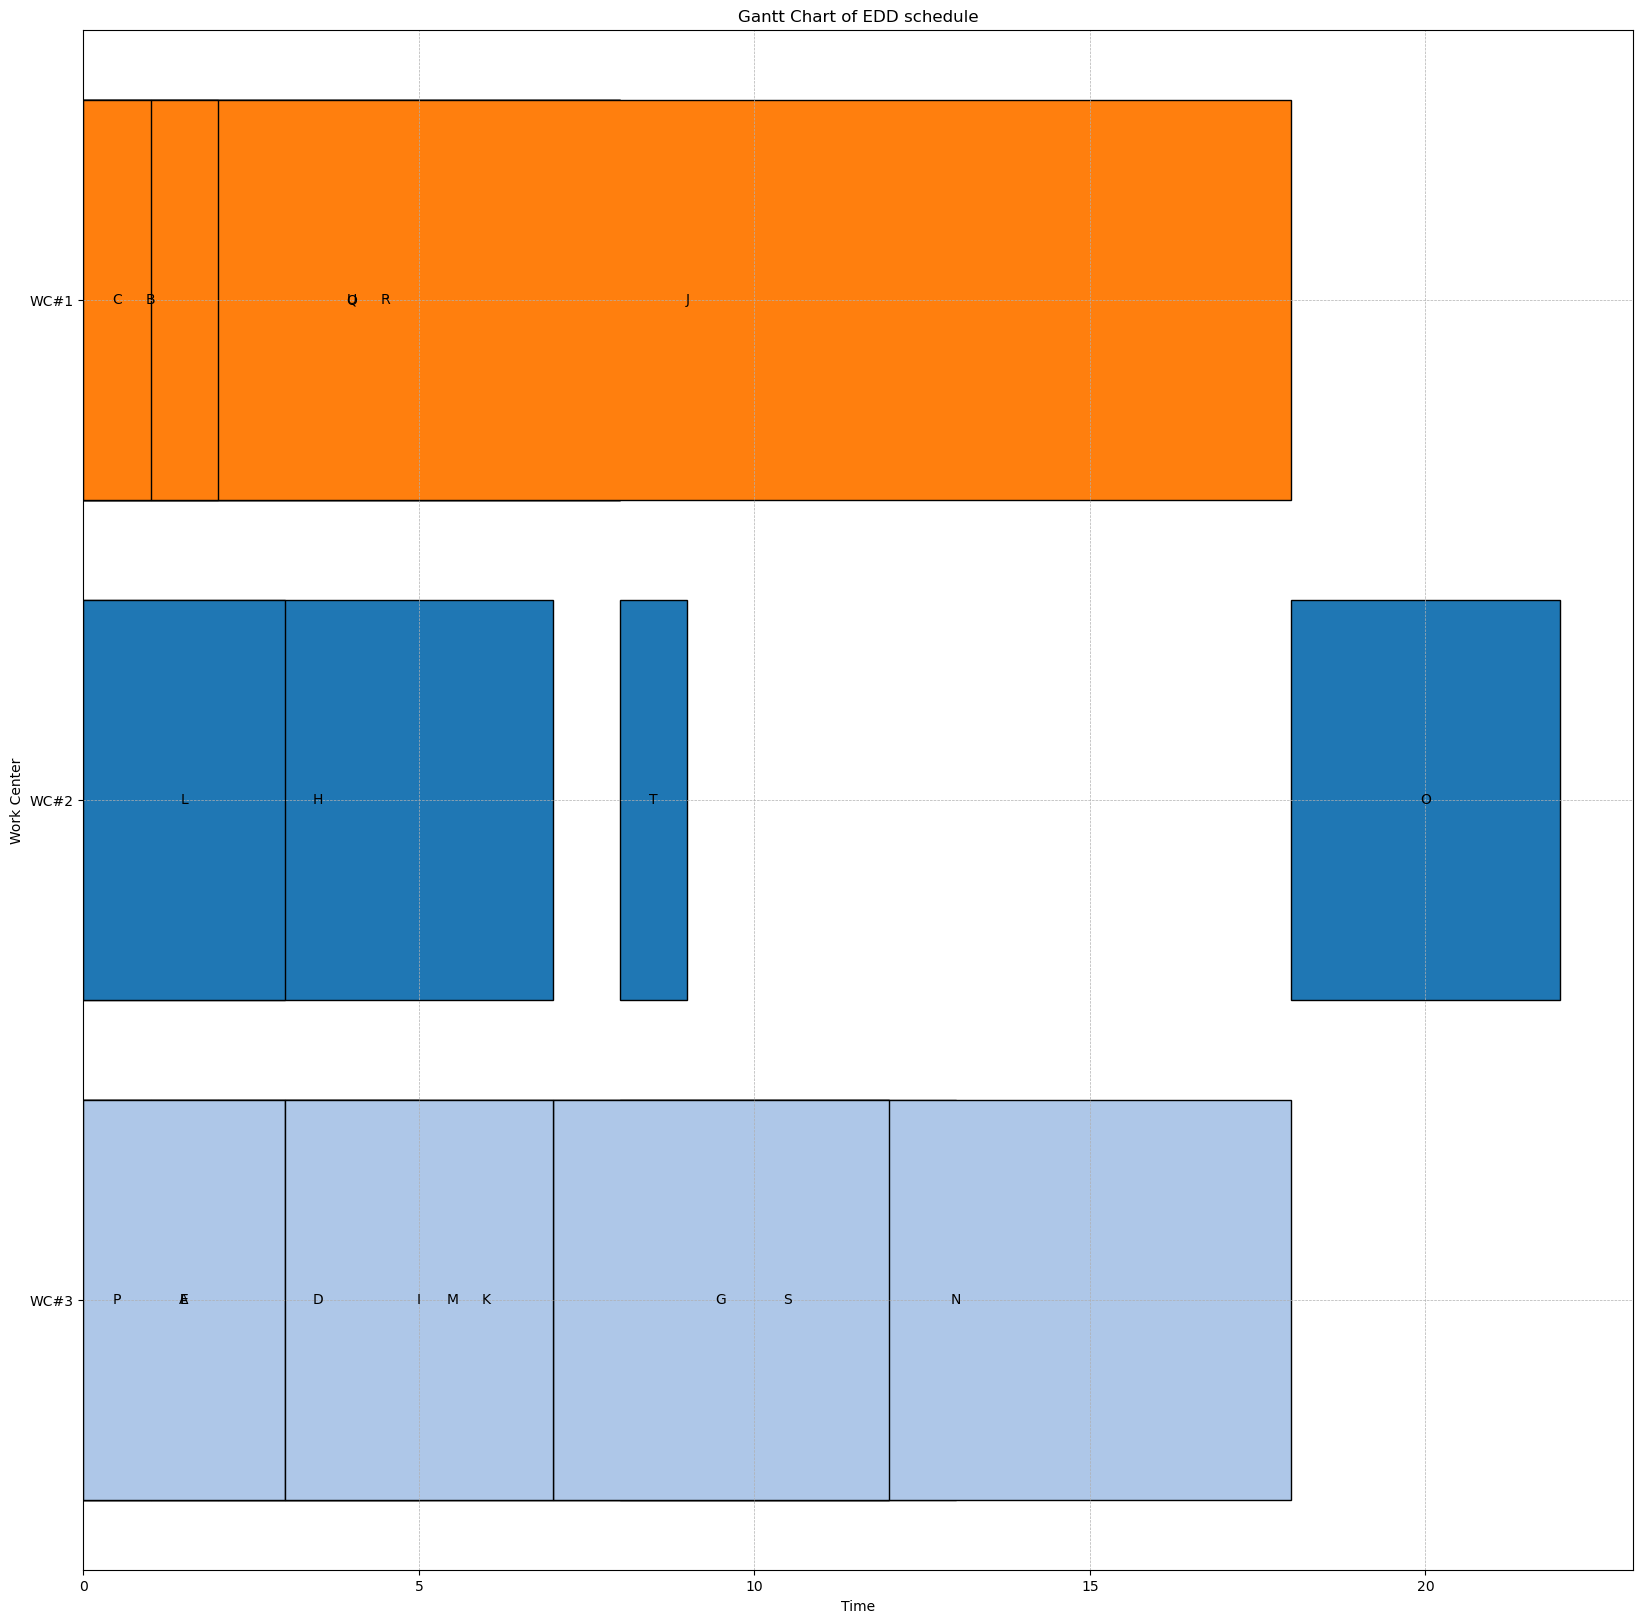

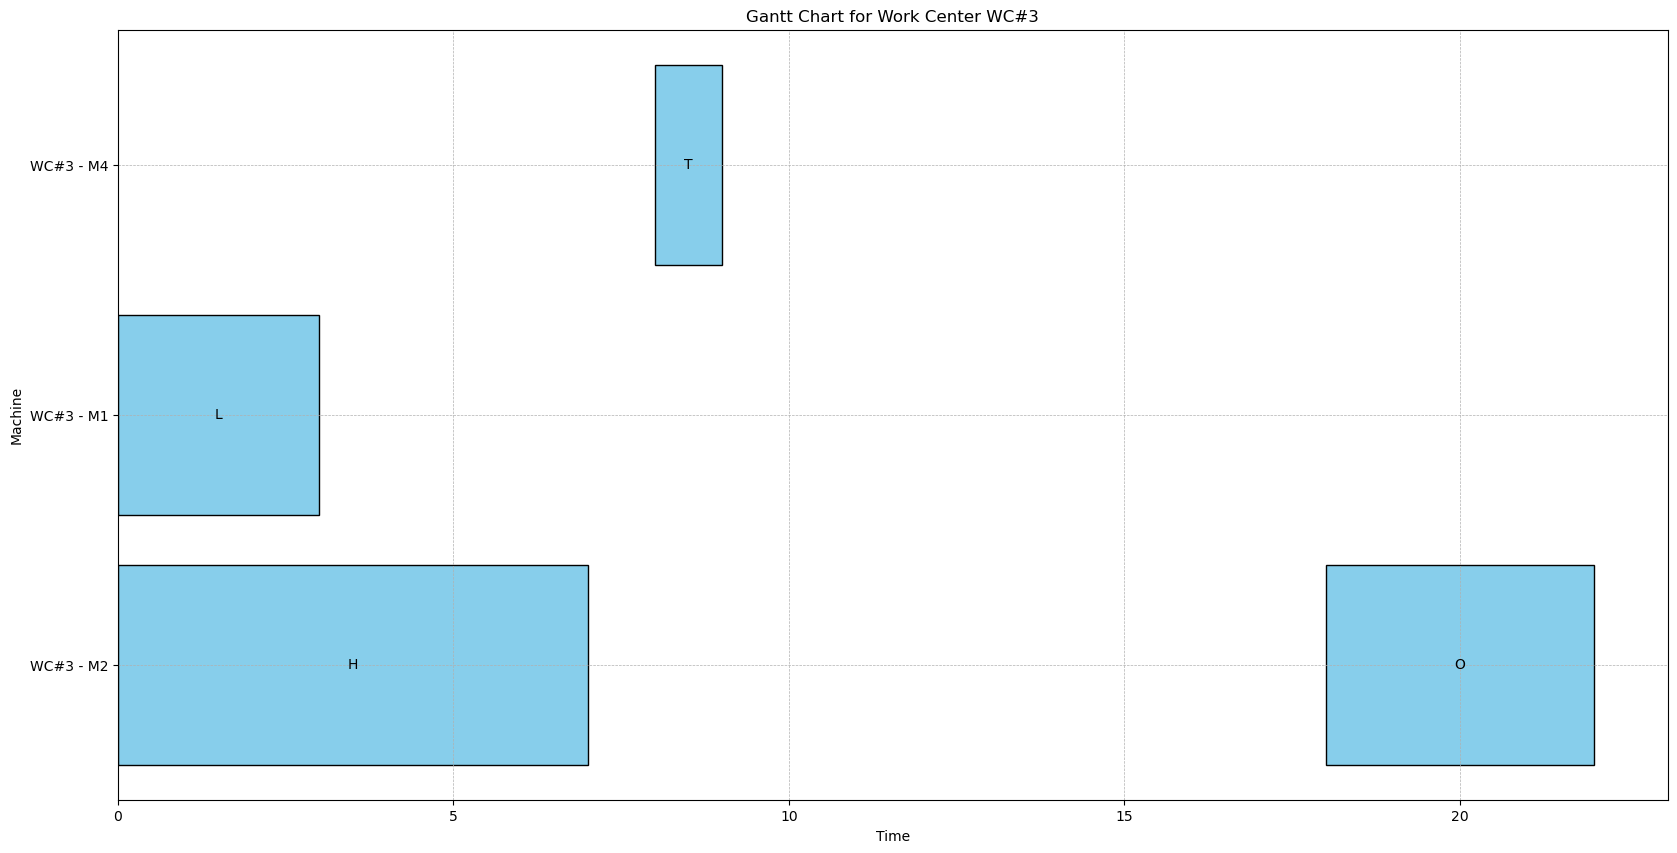

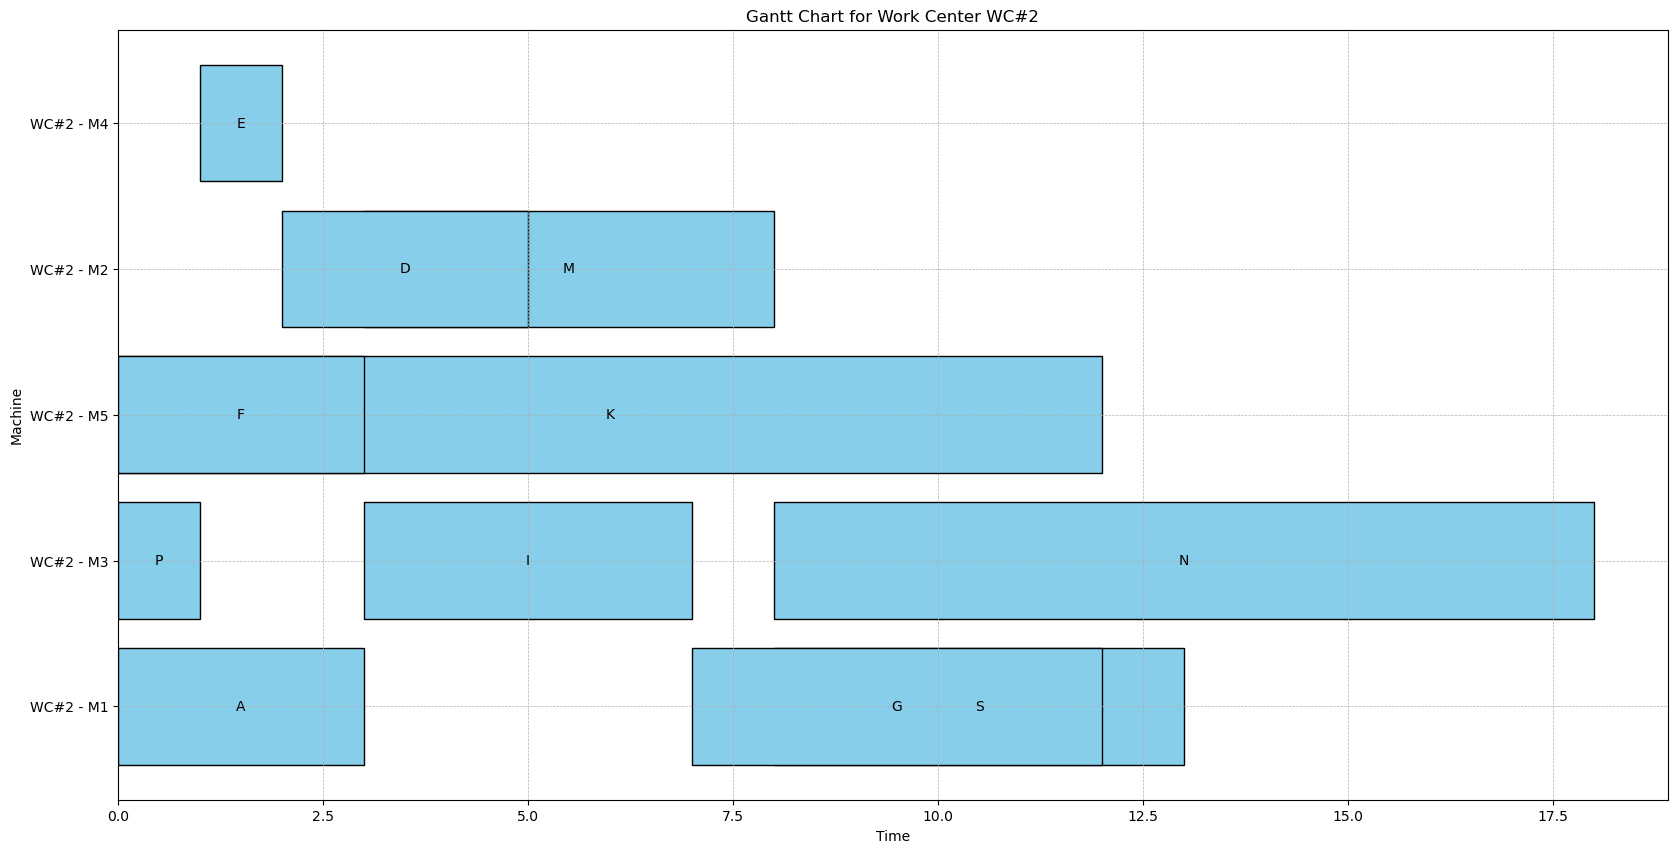

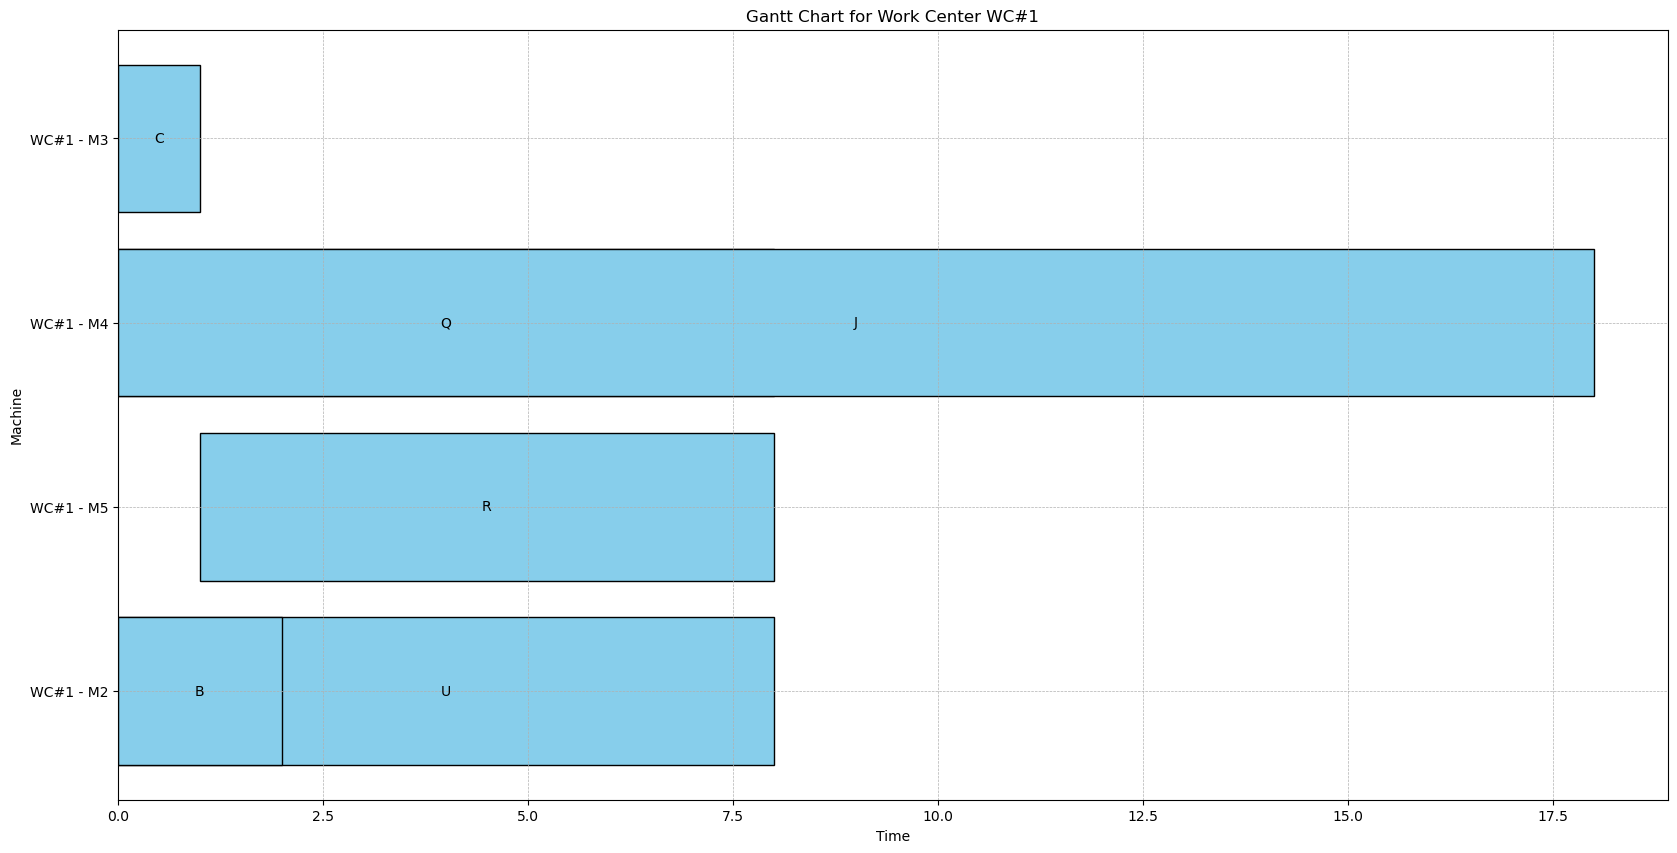

In [106]:
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
})
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2", "WC#3"],
    'M1': [3, 2, 3],
    'M2': [2, 1, 2],
    'M3': [1, 2, 1],
    'M4': [1, 1, 1],
    'M5': [1, 2, 3]
})
display(df_BOM.head())
display(df_machine.head())

factory = load_factory(df_machine)
operations = load_operations_from_df(df_BOM)
# for operation_key in operations.keys():
#     print(f"{operations[operation_key].id} - successor: {operations[operation_key].successor}, predecessors: {operations[operation_key].predecessors}")
scheduled_operations = schedule_operations(operations, factory)

plot_gantt_chart(scheduled_operations)
plot_gantt_chart_by_workcenters(scheduled_operations)
